Install NumPyro by running:
`$ pip install numpyro`

In [1]:
from functools import partial

# Import regular numpy in additional to JAX's
import numpy
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

%run helpers.ipynb

In [2]:
# Compute on a CPU using 2 cores
numpyro.set_platform('cpu')
numpyro.set_host_device_count(2)

# Make plots larger by default
plt.rc('figure', dpi=100)

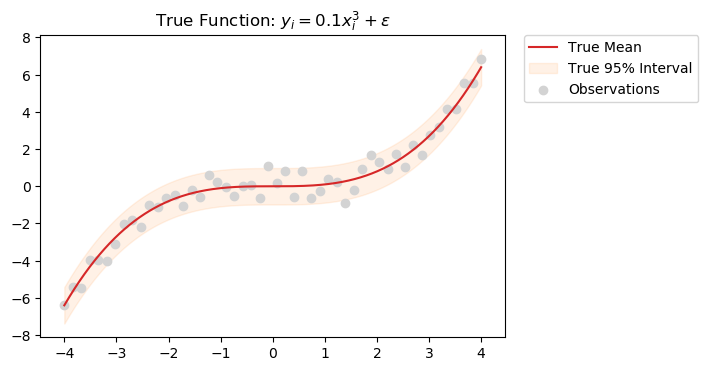

In [3]:
# Define the true function and generate observations
func = lambda x: scipy.stats.norm(loc=0.1 * x**3, scale=0.5)
func.latex = r'$y_i = 0.1x_i^3 + \varepsilon$'

data_points = [
    { 'n_points': 50, 'xlim': [-4, 4] },
]
df = generate_data(func, points=data_points, seed=4)

# Plot the data
plot_true_function(func, df, title=f'True Function: {func.latex}')

In [7]:
# Observations
X = df[['x']].values
Y = df[['y']].values

# Number of hidden layers
hidden = 1
# Width of hidden layers
width = 5
# Standard deviation of the prior
sigma = 2.0
# Standard deviation of the likelihood
noise = 0.5

# Instantiate the model with prior standard deviation and likelihood noise
model = partial(feedforward, X=X, Y=Y, width=width, hidden=hidden, sigma=sigma, noise=noise)

In [8]:
%%time
# NUTS parameters
num_chains = 2
num_samples = 2000
num_warmup = 2000

# Run the No-U-Turn sampler. Note: sampling more than one chain in parallel doesn't show a progress bar
mcmc = sample(model, num_samples, num_warmup, num_chains, seed=0, summary=True)


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   b0[0,0]      0.18      2.70      0.42     -3.96      3.92    319.41      1.01
   b0[0,1]      0.21      2.74      0.49     -3.95      4.05    322.63      1.00
   b0[0,2]      0.10      2.81      0.26     -4.03      4.07    280.00      1.00
   b0[0,3]     -0.02      2.78     -0.05     -3.99      3.96    287.54      1.01
   b0[0,4]     -0.03      2.73     -0.10     -4.02      3.88    287.40      1.01
        b1      0.31      1.30      0.33     -1.90      2.35   1862.65      1.00
   w0[0,0]     -0.06      1.31     -0.12     -2.06      1.84    564.22      1.00
   w0[0,1]     -0.04      1.31     -0.06     -1.98      1.93    482.16      1.00
   w0[0,2]      0.02      1.24      0.10     -1.82      1.79    500.28      1.00
   w0[0,3]     -0.12      1.18     -0.32     -1.72      1.62    472.65      1.00
   w0[0,4]      0.01      1.30      0.08     -1.92      2.12    414.81      1.01
   w1[0,0]     -0.09      2

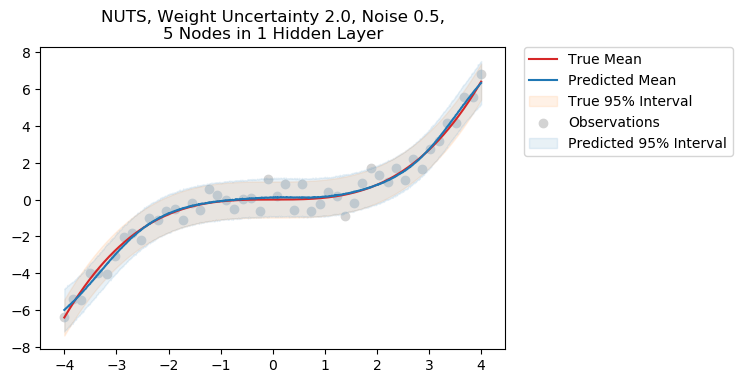

In [9]:
# Generate the posterior predictive
X_test = numpy.linspace(df.x.min(), df.x.max(), num=1000)[:, np.newaxis]
posterior_predictive = simulate_posterior_predictive(model, mcmc, X_test, seed=1)

# Plot the results: truth vs prediction
plot_posterior_predictive(X_test, posterior_predictive, func=func, df=df,
                          title=f'NUTS, Weight Uncertainty {sigma}, Noise {noise},\n'
                                f'{width} Nodes in {hidden} Hidden Layer')